# Regresión Logística para Clasificación de Imágenes

In [2]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix,
                             average_precision_score,
                             plot_precision_recall_curve)

# Funciones de Preprocesamiento


## Detección de Bordes

In [3]:
# Funcion para detectar bordes de cada imagen. Esta funcion
# es pasada como argumento para ImageDataGenerator
SIGMA = 0.33

def find_edges(img, sigma=SIGMA):
    # Cada img está representada como una matriz de enteros
    # con valores entre 0 y 255
    
    # Convertir a tipo float32
    img = np.float32(tf.squeeze(img))
    # Aplicar filtro de blurring 
    blurred = cv2.bilateralFilter(img, 15, 150, 150)
    
    # Encontrar umbrales para detección de bordes usando el valor
    # de la mediana y el parámetro sigma
    v = np.median(blurred)
    lower = int(max(0, (1 - sigma)*v))
    upper = int(min(255, (1 + sigma)*v))
    img = np.uint8(img)
    
    # Detección de bordes usando el algoritmo Canny
    # y conversión del resultado a tensor
    edged = tf.convert_to_tensor(cv2.Canny(img, lower, upper),
                                 dtype=tf.float32)
    x, y = edged.shape
    edged = tf.reshape(edged,[x, y, 1])
    
    return edged

# Data preparation

In [44]:
# ImageGenerator, reescala y aplica la funcion de detección
# de bordes a las imágenes de entrenamiento. 
dims = 30
path = "data"
ig = ImageDataGenerator(validation_split=0.2,
                        rescale = 1./255,
                        preprocessing_function=find_edges)

data_gen = ig.flow_from_directory(directory=path, 
                                  target_size=(dims, dims),
                                  color_mode = "grayscale",
                                  save_format='webp',
                                  batch_size = 813)
data_gen.filenames

Found 813 images belonging to 2 classes.


['cardboard/cardboard1.jpg',
 'cardboard/cardboard10.jpg',
 'cardboard/cardboard100.jpg',
 'cardboard/cardboard101.jpg',
 'cardboard/cardboard102.jpg',
 'cardboard/cardboard103.jpg',
 'cardboard/cardboard104.jpg',
 'cardboard/cardboard105.jpg',
 'cardboard/cardboard106.jpg',
 'cardboard/cardboard107.jpg',
 'cardboard/cardboard108.jpg',
 'cardboard/cardboard109.jpg',
 'cardboard/cardboard11.jpg',
 'cardboard/cardboard110.jpg',
 'cardboard/cardboard111.jpg',
 'cardboard/cardboard112.jpg',
 'cardboard/cardboard113.jpg',
 'cardboard/cardboard114.jpg',
 'cardboard/cardboard115.jpg',
 'cardboard/cardboard116.jpg',
 'cardboard/cardboard117.jpg',
 'cardboard/cardboard118.jpg',
 'cardboard/cardboard119.jpg',
 'cardboard/cardboard12.jpg',
 'cardboard/cardboard120.jpg',
 'cardboard/cardboard121.jpg',
 'cardboard/cardboard122.jpg',
 'cardboard/cardboard123.jpg',
 'cardboard/cardboard124.jpg',
 'cardboard/cardboard125.jpg',
 'cardboard/cardboard126.jpg',
 'cardboard/cardboard127.jpg',
 'cardboard/c

In [6]:
# Imágenes y Labels
images, label = data_gen.next()
# Convertir label a pandas DataFrame
y = pd.DataFrame(label)

# Balancear clases
c1 = sum(y[0])
c2 = len(y) - c1
num_images = int(min(c1, c2))
c1_images = images[y[y[0] == 1].index.tolist()[:num_images]]
c1_label = label[y[y[0] == 1].index.tolist()[:num_images]]
c2_images = images[y[y[0] == 0].index.tolist()[:num_images]]
c2_label = label[y[y[0] == 0].index.tolist()[:num_images]]

# Concatenar muestras de ambas clases 
balanced_images = np.concatenate((c1_images, c2_images))
balanced_label = np.concatenate((c1_label, c2_label))
m, n, _, k = balanced_images.shape

X = []
for i in range(0, m):
    image = balanced_images[i][:, :, 0]
    X_train = np.reshape(image, (1, k*dims*dims))[0]
    X.append(X_train)

X = pd.DataFrame(X)
y = pd.DataFrame(balanced_label)

print(X.shape)
print(y.shape)
print(num_images)

(806, 900)
(806, 2)
403


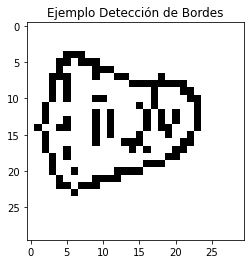

In [72]:
plt.imshow(images[167], cmap=plt.cm.Greys)
plt.title("Ejemplo Detección de Bordes")
plt.show()

In [11]:
# Dividir dataset en training y test
X_train, X_test, y_train, y_test = train_test_split(X, y[0],
                                                    test_size=0.2,
                                                    shuffle=True)

In [12]:
# Entrenar modelo de Regresión Logística Binaria
log = LogisticRegression()
log.fit(X_train, y_train)

LogisticRegression()

In [13]:
# Realizar predicción de clase en muestras no observadas
# en el modelo
y_pred = log.predict(X_test)

# Evaluar la calidad del modelo de clasificación. 

score = log.score(X_test, y_test)
avg_precision = average_precision_score(y_test, y_pred)
print('Precision del modelo: {0:0.2f}'.format(score))
print('Promedio precision-recall score: {0:0.2f}'.format(
      avg_precision))


Precision del modelo: 0.79
Promedio precision-recall score: 0.69


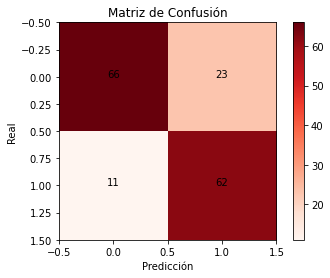

In [15]:
# Calcular matriz de confusión para evaluar la
# calidad del modelo

cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Reds, interpolation='nearest')
plt.colorbar()
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment='center')
plt.show()